In [61]:
import numpy as np

# Const
Q_QUERIES = 1000
N_DOCS = 200
K_TOP = 10

# Simplify the notation
q = Q_QUERIES
n = N_DOCS
k = K_TOP


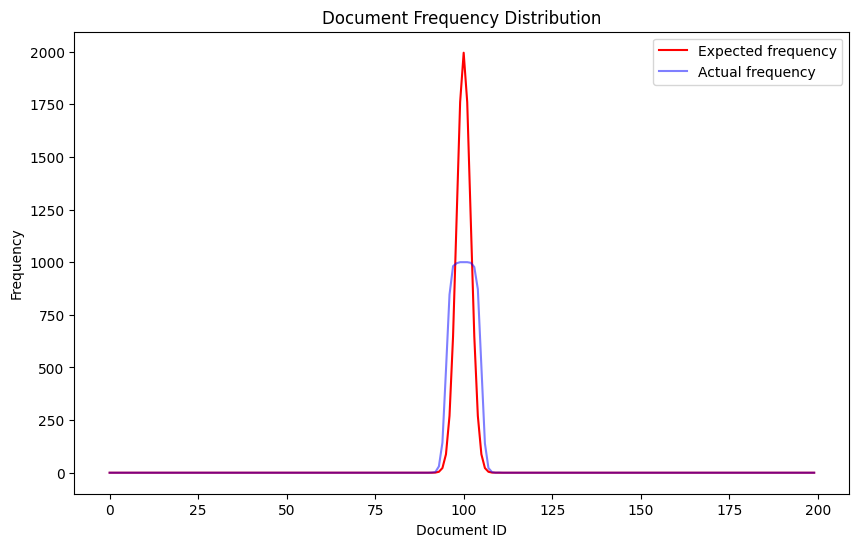

In [62]:
# Generate a Gaussian distribution for document frequencies
# The probability of each document being selected follows a normal distribution
mu = n / 2  # Mean at the center of document range
sigma = n / 100  # Standard deviation to cover most of the range

# Generate probabilities for each document
doc_probs = np.exp(-0.5 * ((np.arange(n) - mu) / sigma) ** 2)
doc_probs = doc_probs / doc_probs.sum()  # Normalize to make it a probability distribution

# Sample documents according to this distribution to create q queries each with k documents
query_docs = []
for _ in range(q):
    # Sample k documents without replacement for each query
    # Using the probability distribution we defined
    sampled_docs = np.random.choice(n, size=k, replace=False, p=doc_probs)
    query_docs.append(sampled_docs)

# Convert to numpy array for easier manipulation
query_docs = np.array(query_docs)  # Shape: (q, k)

# Visualize the distribution of document frequencies
import matplotlib.pyplot as plt

# Count how many times each document appears across all queries
doc_counts = np.zeros(n)
for query in query_docs:
    for doc_id in query:
        doc_counts[doc_id] += 1

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n), doc_probs * q * k, 'r-', label='Expected frequency')
plt.plot(np.arange(n), doc_counts, 'b-', alpha=0.5, label='Actual frequency')
plt.xlabel('Document ID')
plt.ylabel('Frequency')
plt.title('Document Frequency Distribution')
plt.legend()
plt.show()


In [63]:
# Print random 10 queries
print(query_docs[:10])


[[ 97 103 101 100  99  98 102  96 104  94]
 [ 97 101 100 105 102  98  99 103  95 104]
 [100  97  98 103 101 102  99  96 104  95]
 [ 97 100 101 105  99  98 102  96 104 103]
 [101 100  97  96 103 102  99 104 105  98]
 [ 99 103 101 102 100  98 104  96 105  97]
 [101  99  98  97 102 100 104  96 103  94]
 [ 98 102 100 101  99 104  94 103  97  95]
 [101 103  99 100  98 104 102  96  94  97]
 [ 99 101 103  98 100 105  96 104  97 102]]


In [66]:
def get_distance(query_1, query_2, method="sharp"):
    # get the distance between two queries (or similarity)
    k1 = len(query_1)
    k2 = len(query_2)
    max_k = max(k1, k2)
    same_items = len(np.intersect1d(query_1, query_2))
    if method == "direct":
        return same_items / max_k
    elif method == "square":
        return (same_items / max_k) ** 2
    elif method == "sharp":
        # f(x) = (e^(ax^2) - 1)/(e^a - 1), a = 2
        a = 2
        x = same_items / max_k
        return (np.exp(a * x**2) - 1) / (np.exp(a) - 1)
    else:
        # default to sharp
        # f(x) = (e^(ax^2) - 1)/(e^a - 1), a = 2
        a = 2
        x = same_items / max_k
        return (np.exp(a * x**2) - 1) / (np.exp(a) - 1)

# test the function
random_query_1 = np.random.choice(n, size=k, replace=False, p=doc_probs)
random_query_2 = np.random.choice(n, size=k, replace=False, p=doc_probs)
print(random_query_1)
print(random_query_2)
same_items = len(np.intersect1d(random_query_1, random_query_2))
print(same_items)
print(get_distance(random_query_1, random_query_2, method="direct"))
print(get_distance(random_query_1, random_query_2, method="square"))
print(get_distance(random_query_1, random_query_2, method="sharp"))


[ 97 100  98  99  94 101 105  95 104  96]
[100 101 102 104  99  98  97  95 103 105]
8
0.8
0.6400000000000001
0.4064199289162428



--- Cluster Tree Node Information (with Frequency) ---
Node 0 (Leaf):
  Content (10 items): [94, 96, 97, 98, 99, 100, 101, 102, 103, 104]
  Frequency (Original queries matching this exact content): 1
  Total Original Queries in Subtree: 1
  Original Indices: [0]
--------------------
Node 1 (Leaf):
  Content (10 items): [95, 97, 98, 99, 100, 101, 102, 103, 104, 105]
  Frequency (Original queries matching this exact content): 1
  Total Original Queries in Subtree: 1
  Original Indices: [1]
--------------------
Node 2 (Leaf):
  Content (10 items): [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
  Frequency (Original queries matching this exact content): 1
  Total Original Queries in Subtree: 1
  Original Indices: [2]
--------------------
Node 3 (Leaf):
  Content (10 items): [96, 97, 98, 99, 100, 101, 102, 103, 104, 105]
  Frequency (Original queries matching this exact content): 1
  Total Original Queries in Subtree: 1
  Original Indices: [3]
--------------------
Node 4 (Leaf):
  Content (

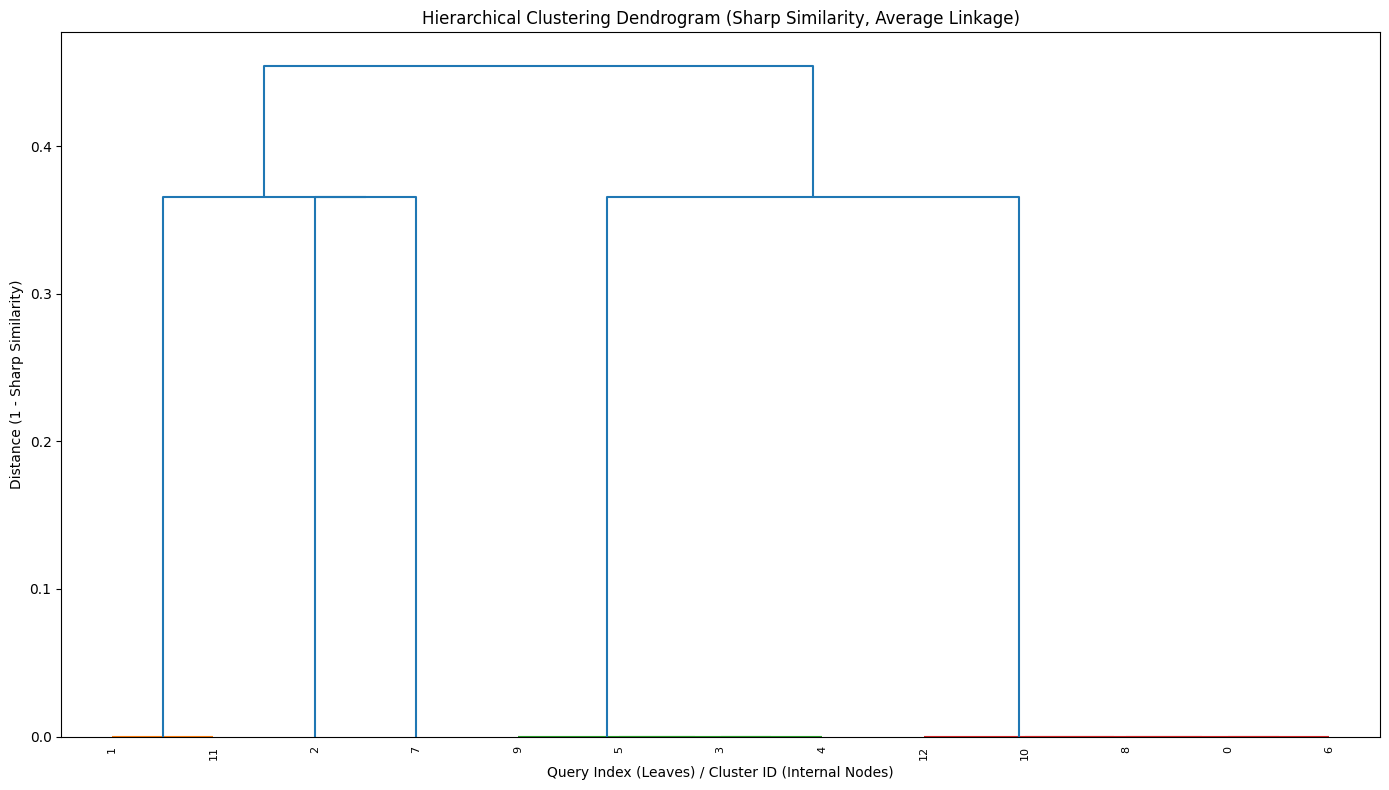


Checking frequency for content: [94, 96, 97, 98, 99, 100, 101, 102, 103, 104]
  Node 0: Frequency=1, Orig_Indices=[0]
  Node 6: Frequency=1, Orig_Indices=[6]
  Node 8: Frequency=1, Orig_Indices=[8]
  Node 10: Frequency=1, Orig_Indices=[10]
  Node 12: Frequency=1, Orig_Indices=[12]
  Node 13: Frequency=2, Orig_Indices=[0, 6]
  Node 17: Frequency=3, Orig_Indices=[0, 6, 8]
  Node 19: Frequency=4, Orig_Indices=[0, 6, 8, 10]
  Node 20: Frequency=5, Orig_Indices=[0, 6, 8, 10, 12]


In [1]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import collections

# (get_distance function remains the same as in the previous version)
def get_distance(query_1, query_2, method="sharp"):
    """
    Calculates the similarity between two queries (lists or arrays of items).
    [Function content identical to previous answer - omitted for brevity]
    """
    # Ensure inputs are numpy arrays for intersect1d
    q1 = np.asarray(query_1)
    q2 = np.asarray(query_2)

    k1 = len(q1)
    k2 = len(q2)
    if k1 == 0 or k2 == 0:
      return 0.0

    max_k = max(k1, k2)
    # Use direct intersection if presence matters more than count/order
    same_items = len(np.intersect1d(q1, q2))

    # Avoid division by zero if max_k is 0 (both queries empty)
    if max_k == 0:
        return 1.0 # Both empty, max similarity

    x = same_items / max_k

    if method == "direct":
        return x
    elif method == "square":
        return x ** 2
    elif method == "sharp":
        # f(x) = (e^(ax^2) - 1)/(e^a - 1), a = 2
        a = 2
        exp_a = np.exp(a)
        if exp_a == 1: # Avoid division by zero if a=0
             return x**2 # Limit case as a -> 0
        # Use np.clip to avoid potential precision issues near x=0 or x=1
        val = (np.exp(a * x**2) - 1) / (exp_a - 1)
        return np.clip(val, 0.0, 1.0)
    else:
        # default to sharp
        a = 2
        exp_a = np.exp(a)
        if exp_a == 1:
             return x**2
        val = (np.exp(a * x**2) - 1) / (exp_a - 1)
        return np.clip(val, 0.0, 1.0)


def clustering(queries, similarity_method="sharp", linkage_method='average'):
    """
    Performs hierarchical clustering, calculating intersection content and frequency.

    Frequency represents how many original queries exactly match the content set of this node.

    Args:
        queries (list of lists/np.arrays): Input queries.
        similarity_method (str): Similarity method for get_distance.
        linkage_method (str): Linkage method for scipy's linkage.

    Returns:
        tuple: A tuple containing:
            - Z (np.ndarray): The linkage matrix.
            - cluster_nodes (dict): Dictionary mapping node IDs (0 to 2n-2) to info:
                                    {'content': set, 'original_indices': set,
                                     'distance': float, 'children': tuple or None,
                                     'frequency': int}.
    """
    n = len(queries)
    # Pre-calculate content sets for original queries for efficiency
    original_query_sets = [set(q) for q in queries]

    if n < 2:
        print("Need at least two queries.")
        cluster_nodes = {}
        for i in range(n):
             query_set = original_query_sets[i]
             cluster_nodes[i] = {
                 'content': query_set,
                 'original_indices': {i},
                 'distance': 0.0,
                 'children': None,
                 'frequency': 1 # Each original query matches itself
             }
        return np.empty((0, 4)), cluster_nodes

    # 1. Calculate distance matrix
    condensed_dist_matrix = np.zeros(n * (n - 1) // 2)
    k = 0
    for i in range(n):
        for j in range(i + 1, n):
            # Use pre-calculated sets if distance func worked with sets,
            # but get_distance uses original lists/arrays.
            similarity = get_distance(queries[i], queries[j], method=similarity_method)
            distance = 1.0 - similarity
            condensed_dist_matrix[k] = max(0.0, distance)
            k += 1

    # 2. Perform hierarchical clustering
    Z = linkage(condensed_dist_matrix, method=linkage_method)

    # 3. Build cluster representation including frequency
    cluster_nodes = {}

    # Initialize leaf nodes (0 to n-1)
    for i in range(n):
        query_set = original_query_sets[i]
        cluster_nodes[i] = {
            'content': query_set,
            'original_indices': {i},
            'distance': 0.0,
            'children': None,
            'frequency': 1 # Frequency of leaf node matching its own content is 1
        }

    # Process merges (internal nodes n to 2n-2)
    for i in range(Z.shape[0]):
        new_cluster_id = n + i
        idx1, idx2, dist, num_items = Z[i]
        idx1, idx2 = int(idx1), int(idx2)

        cluster1_info = cluster_nodes.get(idx1)
        cluster2_info = cluster_nodes.get(idx2)

        if not cluster1_info or not cluster2_info:
            print(f"CRITICAL Error: Missing info for child {idx1} or {idx2} at merge {i}")
            continue # Skip this merge if children info is missing

        # Calculate intersection content and combined original indices
        new_content = cluster1_info['content'].intersection(cluster2_info['content'])
        new_original_indices = cluster1_info['original_indices'].union(cluster2_info['original_indices'])

        # Calculate frequency for this new node's specific content
        # Count how many original queries within its subtree exactly match its content
        new_frequency = 0
        for original_idx in new_original_indices:
            # Check if the original query's set matches the new node's intersection content
            if original_query_sets[original_idx] == new_content:
                new_frequency += 1

        # Store info for the new cluster node
        cluster_nodes[new_cluster_id] = {
            'content': new_content,
            'original_indices': new_original_indices,
            'distance': dist,
            'children': (idx1, idx2),
            'frequency': new_frequency
        }

    return Z, cluster_nodes

# --- Updated Debug Module ---
def print_cluster_tree_content(n, cluster_nodes):
    """
    Prints the content, frequency, and other info for every node.

    Args:
        n (int): The number of original queries (leaf nodes).
        cluster_nodes (dict): Dictionary from the clustering function.
    """
    print("\n--- Cluster Tree Node Information (with Frequency) ---")
    num_total_nodes = 2 * n - 1 if n > 0 else 0

    for node_id in range(num_total_nodes):
        if node_id not in cluster_nodes:
            print(f"Node {node_id}: Information not found (Error?)")
            continue

        info = cluster_nodes[node_id]
        content_list = sorted(list(info['content']))
        original_indices_list = sorted(list(info['original_indices']))
        total_original_count = len(info['original_indices'])
        frequency = info['frequency'] # Frequency of exact content match

        print(f"Node {node_id} ({'Leaf' if node_id < n else 'Internal'}):")
        print(f"  Content ({len(content_list)} items): {content_list}")
        print(f"  Frequency (Original queries matching this exact content): {frequency}")
        print(f"  Total Original Queries in Subtree: {total_original_count}")
        print(f"  Original Indices: {original_indices_list}")

        if node_id >= n: # Internal node specific info
            print(f"  Merge Distance: {info['distance']:.4f}")
            print(f"  Children Nodes: {info['children']}")
        print("-" * 20) # Separator


# --- Example Usage ---
queries = [
    [ 97, 103, 101, 100,  99,  98, 102,  96, 104,  94], # 0
    [ 97, 101, 100, 105, 102,  98,  99, 103,  95, 104], # 1
    [100,  97,  98, 103, 101, 102,  99,  96, 104,  95], # 2
    [ 97, 100, 101, 105,  99,  98, 102,  96, 104, 103], # 3
    [101, 100,  97,  96, 103, 102,  99, 104, 105,  98], # 4
    [ 99, 103, 101, 102, 100,  98, 104,  96, 105,  97], # 5
    [101,  99,  98,  97, 102, 100, 104,  96, 103,  94], # 6 Same unique items as 0
    [ 98, 102, 100, 101,  99, 104,  94, 103,  97,  95], # 7
    [101, 103,  99, 100,  98, 104, 102,  96,  94,  97], # 8 Same unique items as 0, 6
    [ 99, 101, 103,  98, 100, 105,  96, 104,  97, 102]  # 9
]

# Add duplicates to test frequency accumulation based on identical sets
queries.append(list(queries[0])) # 10 is identical to 0
queries.append([ 97, 101, 100, 105, 102,  98,  99, 103,  95, 104]) # 11 is identical to 1
queries.append(list(queries[8])) # 12 is identical to 8 (and thus 0, 6)


n_queries = len(queries) # Now n=13

# Perform clustering
Z, cluster_nodes = clustering(queries, similarity_method="sharp", linkage_method='average')

# --- Use the Debug Module ---
print_cluster_tree_content(n_queries, cluster_nodes)

# --- Optional: Visualize the dendrogram ---
if n_queries >= 2:
    plt.figure(figsize=(14, 8)) # Wider figure for more leaves
    plt.title('Hierarchical Clustering Dendrogram (Sharp Similarity, Average Linkage)')
    plt.xlabel('Query Index (Leaves) / Cluster ID (Internal Nodes)')
    plt.ylabel('Distance (1 - Sharp Similarity)')

    leaf_labels = [str(i) for i in range(n_queries)]

    dendrogram(Z,
               leaf_rotation=90.,
               leaf_font_size=8.,
               labels=leaf_labels,
               )
    plt.tight_layout()
    plt.show()

# --- Example: Check a node known to have high frequency ---
# Find the content set for query 0
content_of_0 = set(queries[0])
print(f"\nChecking frequency for content: {sorted(list(content_of_0))}")
for node_id, info in cluster_nodes.items():
    if info['content'] == content_of_0:
        print(f"  Node {node_id}: Frequency={info['frequency']}, Orig_Indices={sorted(list(info['original_indices']))}")
        # Expect freq=4 for nodes 0, 6, 8, 10, 12 if they merge correctly
        # Note: Intermediate merge nodes might also have this content set
